In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report



In [4]:
negative_dir = Path('/content/drive/MyDrive/negative final')
positive_dir = Path('/content/drive/MyDrive/positive final')

In [5]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [6]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,/content/drive/MyDrive/negative final/00128.jpg,NEGATIVE
1,/content/drive/MyDrive/positive final/00271.jpg,POSITIVE
2,/content/drive/MyDrive/negative final/00075.jpg,NEGATIVE
3,/content/drive/MyDrive/negative final/00215.jpg,NEGATIVE
4,/content/drive/MyDrive/positive final/00181.jpg,POSITIVE
...,...,...
593,/content/drive/MyDrive/positive final/00171.jpg,POSITIVE
594,/content/drive/MyDrive/positive final/00156.jpg,POSITIVE
595,/content/drive/MyDrive/positive final/00080.jpg,POSITIVE
596,/content/drive/MyDrive/positive final/00219.jpg,POSITIVE


In [10]:

train_df, test_df = train_test_split(
    all_df.sample(250, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)




In [11]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [12]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 140 validated image filenames belonging to 2 classes.
Found 35 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.


In [13]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 32)        0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (  (None, 32)                0     

In [14]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
5/5 [==============================] - 15s 3s/step - loss: 0.6520 - accuracy: 0.5786 - val_loss: 0.6309 - val_accuracy: 0.6000
Epoch 2/100
5/5 [==============================] - 3s 536ms/step - loss: 0.6460 - accuracy: 0.5786 - val_loss: 0.6191 - val_accuracy: 0.6000
Epoch 3/100
5/5 [==============================] - 2s 331ms/step - loss: 0.6370 - accuracy: 0.5786 - val_loss: 0.6176 - val_accuracy: 0.6000
Epoch 4/100
5/5 [==============================] - 2s 370ms/step - loss: 0.6325 - accuracy: 0.5786 - val_loss: 0.6125 - val_accuracy: 0.6000
Epoch 5/100
5/5 [==============================] - 2s 329ms/step - loss: 0.6282 - accuracy: 0.5786 - val_loss: 0.6093 - val_accuracy: 0.6000
Epoch 6/100
5/5 [==============================] - 3s 612ms/step - loss: 0.6221 - accuracy: 0.5786 - val_loss: 0.6016 - val_accuracy: 0.6000
Epoch 7/100
5/5 [==============================] - 3s 430ms/step - loss: 0.6148 - accuracy: 0.5786 - val_loss: 0.5930 - val_accuracy: 0.6000
Epoch 8/100
5/5

In [15]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

In [16]:
def evaluate_model(model, test_data):

    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]

    print("Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))

    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:\n----------------------\n", clr)

Test Loss: 0.29611
Test Accuracy: 92.00%
3/3 [==============================] - 1s 81ms/step


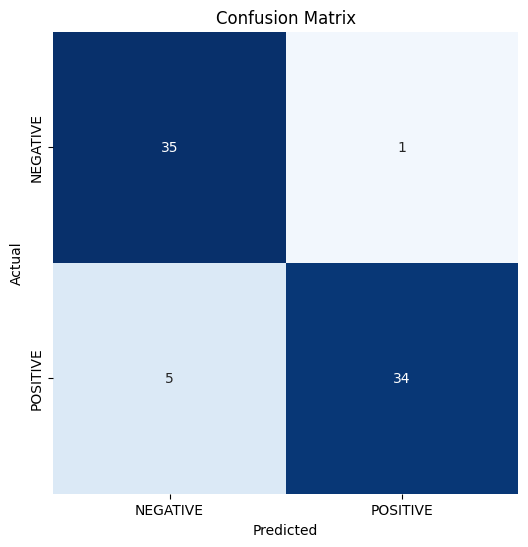

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.88      0.97      0.92        36
    POSITIVE       0.97      0.87      0.92        39

    accuracy                           0.92        75
   macro avg       0.92      0.92      0.92        75
weighted avg       0.93      0.92      0.92        75



In [17]:
evaluate_model(model, test_data)

In [18]:
import numpy as np
import tensorflow as tf
from google.colab import files
from tensorflow.keras.preprocessing import image

In [29]:
uploaded = files.upload()

for fn in uploaded.keys():
    # Load and preprocess the image
    img = image.load_img(fn, target_size=(120, 120))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict using the model
    prediction = model.predict(img_array)
    if prediction[0][0]<0.22:
      print("not damaged")
    else:
      print("damaged")




Saving bmir.jpeg to bmir.jpeg
1/1 [==============================] - 0s 23ms/step
damaged


In [31]:
from tensorflow.keras.models import load_model
model.save('/content/DamageDetection.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
